# Discrimination des solutions de la surface de Pareto

### Imports

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata
from gurobipy import Model, GRB, quicksum

## Small dataset

### Import des données

In [45]:
with open("solutions/small/solutions.json") as f:
    data = json.load(f)

In [46]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day":results[:,0],
    "NbProject":results[:,1],
    "Price":results[:,2]
})
results_pd

,Day,NbProject,Price
0,5.0,5.0,65.0
1,5.0,4.0,65.0
2,5.0,3.0,65.0
3,5.0,2.0,65.0
4,5.0,1.0,59.0
5,4.0,5.0,65.0
6,4.0,4.0,65.0
7,4.0,3.0,65.0
8,4.0,2.0,65.0
9,4.0,1.0,59.0


### Visualisations

C:\Users\flavi\AppData\Local\Temp\ipykernel_24300\484413676.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


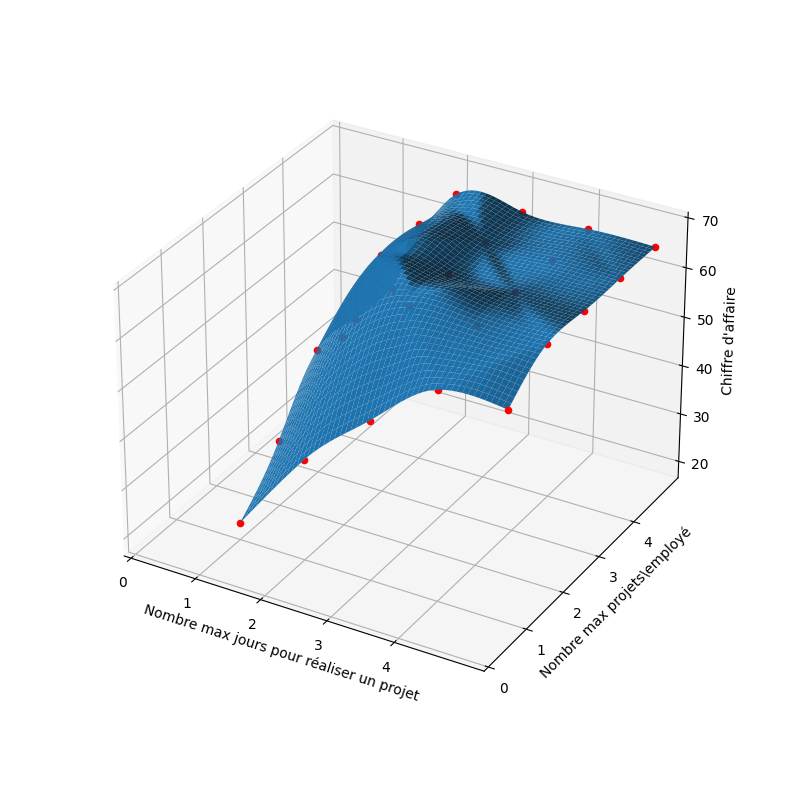

In [47]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()


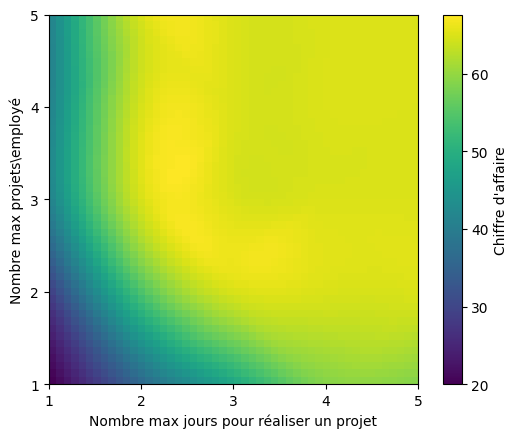

In [48]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1,int(max(x)+1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1,int(max(y)+1)))
plt.show()

### Catégorisation des solutions

In [37]:
# Implémentation Python
num_edt, dim = results.shape
epsilon = 0

m = Model("Preferences")
# W : Dict[int, Var]
W = {d : m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'w{d}') for d in range(dim)}

#u_i = Sum_j(x_i*w_j) + delta_i_plus - delta_i_moins 

# S => on veut erreur proche de 1 (loin de 2/3) => d_plus
# C => on veut erreur loin de 1/3 et loin de 2/3 (proche de 1/2) => d_plus et d_moins
# I => on veut erreur proche de 0 (loin de 1/3) => d_moins

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {j : quicksum([W[i]*results[j][i] for i in range(dim)])/max(results[j]) - d_plus[j] - d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[1] <= 1/3, name="C_1")
m.addConstr(EdtDictLinExpr[2] <= 1/3, name="C_2")
m.addConstr(EdtDictLinExpr[5] <= 1/3, name="C_3")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[7] <= 2/3, name="C_4")
m.addConstr(EdtDictLinExpr[7] >= 1/3, name="C_5")
m.addConstr(EdtDictLinExpr[10] <= 2/3, name="C_6")
m.addConstr(EdtDictLinExpr[10] >= 1/3, name="C_7")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[12] >= 2/3, name="C_8")
m.addConstr(EdtDictLinExpr[12] <= 1, name="C_9")
m.addConstr(EdtDictLinExpr[15] >= 2/3, name="C_10")
m.addConstr(EdtDictLinExpr[15] <= 1, name="C_11")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MINIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [np.dot(result,weights)/max(result) for result in results]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(lambda x : 'Inacceptable' if x < 1/3 else ('Correcte' if x < 2/3 else 'Satisfaisante')) 
results_pd

Optimal
[0.0, 0.0, 1.0]


,Day,NbProject,Price,score,status
0,5.0,5.0,65.0,1.0,Satisfaisante
1,5.0,4.0,65.0,1.0,Satisfaisante
2,5.0,3.0,65.0,1.0,Satisfaisante
3,5.0,2.0,65.0,1.0,Satisfaisante
4,5.0,1.0,59.0,1.0,Satisfaisante
5,4.0,5.0,65.0,1.0,Satisfaisante
6,4.0,4.0,65.0,1.0,Satisfaisante
7,4.0,3.0,65.0,1.0,Satisfaisante
8,4.0,2.0,65.0,1.0,Satisfaisante
9,4.0,1.0,59.0,1.0,Satisfaisante


## Medium dataset

### Import des données

In [39]:
with open("solutions/medium/solutions.json") as f:
    data = json.load(f)

In [40]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day":results[:,0],
    "NbProject":results[:,1],
    "Price":results[:,2]
})
results_pd

,Day,NbProject,Price
0,22.0,15.0,413.0
1,22.0,14.0,413.0
2,22.0,13.0,413.0
3,22.0,12.0,413.0
4,22.0,11.0,413.0
...,...,...,...
325,1.0,5.0,120.0
326,1.0,4.0,90.0
327,1.0,3.0,80.0
328,1.0,2.0,30.0


### Visualisations

C:\Users\flavi\AppData\Local\Temp\ipykernel_24300\484413676.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


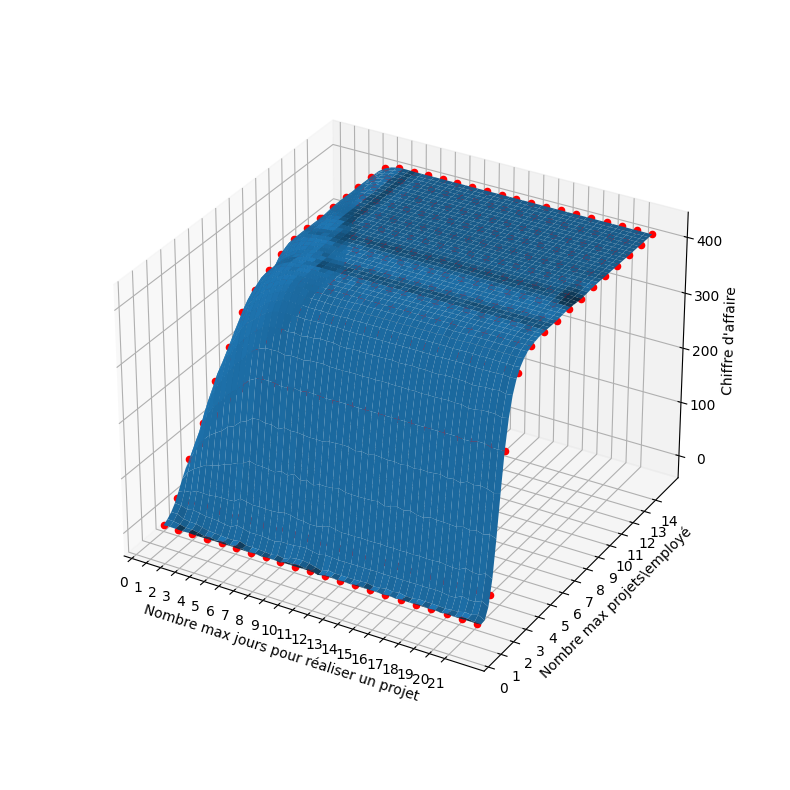

In [41]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()


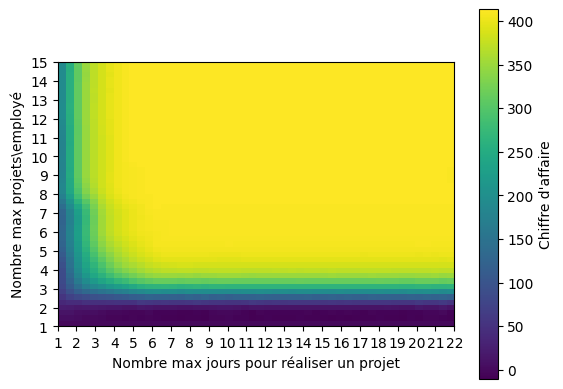

In [42]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1,int(max(x)+1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1,int(max(y)+1)))
plt.show()

### Catégorisation des solutions

In [43]:
# Implémentation Python
num_edt, dim = results.shape
epsilon = 0

m = Model("Preferences")
# W : Dict[int, Var]
W = {d : m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'w{d}') for d in range(dim)}

#u_i = Sum_j(x_i*w_j) + delta_i_plus - delta_i_moins 

# S => on veut erreur proche de 1 (loin de 2/3) => d_plus
# C => on veut erreur loin de 1/3 et loin de 2/3 (proche de 1/2) => d_plus et d_moins
# I => on veut erreur proche de 0 (loin de 1/3) => d_moins

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {j : quicksum([W[i]*results[j][i] for i in range(dim)])/max(results[j]) - d_plus[j] - d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[1] <= 1/3, name="C_1")
m.addConstr(EdtDictLinExpr[2] <= 1/3, name="C_2")
m.addConstr(EdtDictLinExpr[5] <= 1/3, name="C_3")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[7] <= 2/3, name="C_4")
m.addConstr(EdtDictLinExpr[7] >= 1/3, name="C_5")
m.addConstr(EdtDictLinExpr[10] <= 2/3, name="C_6")
m.addConstr(EdtDictLinExpr[10] >= 1/3, name="C_7")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[12] >= 2/3, name="C_8")
m.addConstr(EdtDictLinExpr[12] <= 1, name="C_9")
m.addConstr(EdtDictLinExpr[15] >= 2/3, name="C_10")
m.addConstr(EdtDictLinExpr[15] <= 1, name="C_11")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MINIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [np.dot(result,weights)/max(result) for result in results]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(lambda x : 'Inacceptable' if x < 1/3 else ('Correcte' if x < 2/3 else 'Satisfaisante')) 
results_pd

Optimal
[0.1522537562604346, 0.19593767390094552, 0.6518085698386199]


,Day,NbProject,Price,score,status
0,22.0,15.0,413.0,0.667035,Satisfaisante
1,22.0,14.0,413.0,0.666561,Correcte
2,22.0,13.0,413.0,0.666086,Correcte
3,22.0,12.0,413.0,0.665612,Correcte
4,22.0,11.0,413.0,0.665138,Correcte
...,...,...,...,...,...
325,1.0,5.0,120.0,0.661241,Correcte
326,1.0,4.0,90.0,0.662209,Correcte
327,1.0,3.0,80.0,0.661059,Correcte
328,1.0,2.0,30.0,0.669946,Satisfaisante


## Large dataset

### Import des données

In [ ]:
with open("solutions/large/solutions.json") as f:
    data = json.load(f)

In [ ]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day":results[:,0],
    "NbProject":results[:,1],
    "Price":results[:,2]
})
results_pd

### Visualisations

In [ ]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1,int(max(x)+1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1,int(max(y)+1)))
plt.show()

### Catégorisation des solutions

In [ ]:
# Implémentation Python
num_edt, dim = results.shape
epsilon = 0

m = Model("Preferences")
# W : Dict[int, Var]
W = {d : m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'w{d}') for d in range(dim)}

#u_i = Sum_j(x_i*w_j) + delta_i_plus - delta_i_moins 

# S => on veut erreur proche de 1 (loin de 2/3) => d_plus
# C => on veut erreur loin de 1/3 et loin de 2/3 (proche de 1/2) => d_plus et d_moins
# I => on veut erreur proche de 0 (loin de 1/3) => d_moins

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name = f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {j : quicksum([W[i]*results[j][i] for i in range(dim)])/max(results[j]) - d_plus[j] - d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[1] <= 1/3, name="C_1")
m.addConstr(EdtDictLinExpr[2] <= 1/3, name="C_2")
m.addConstr(EdtDictLinExpr[5] <= 1/3, name="C_3")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[7] <= 2/3, name="C_4")
m.addConstr(EdtDictLinExpr[7] >= 1/3, name="C_5")
m.addConstr(EdtDictLinExpr[10] <= 2/3, name="C_6")
m.addConstr(EdtDictLinExpr[10] >= 1/3, name="C_7")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[12] >= 2/3, name="C_8")
m.addConstr(EdtDictLinExpr[12] <= 1, name="C_9")
m.addConstr(EdtDictLinExpr[15] >= 2/3, name="C_10")
m.addConstr(EdtDictLinExpr[15] <= 1, name="C_11")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MINIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [np.dot(result,weights)/max(result) for result in results]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(lambda x : 'Inacceptable' if x < 1/3 else ('Correcte' if x < 2/3 else 'Satisfaisante')) 
results_pd